In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from maddeb.Deblender import Deblend
from maddeb.utils import listdir_fullpath
from maddeb.extraction import extract_cutouts

import numpy as np
import os

import matplotlib.pyplot as plt

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import tensorflow as tf
import tensorflow_probability as tfp
tf.get_logger().setLevel('ERROR')

from maddeb.utils import CustomSampling

2023-02-11 23:31:57.175004: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-02-11 23:31:57.175036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import seaborn as sns
sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

# Generate the blended scene

In [3]:
COSMOS_CATALOG_PATHS = "/sps/lsst/users/bbiswas/OneDegSq_snr_10.fits"

stamp_size = 41
min_number = 8
max_number = 15
batch_size = 2
maxshift = 15
num_repetations = 15
catalog = btk.catalog.CatsimCatalog.from_file(COSMOS_CATALOG_PATHS)
survey = btk.survey.get_surveys("LSST")
seed = 13
run_name = "test_run_catsim"

linear_norm_coeff = [1000, 5000, 10000, 10000, 10000, 10000]

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_number, min_number=min_number, max_shift=maxshift, stamp_size=stamp_size, seed=seed
)

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    cpus=1,
    add_noise="all",
    verbose=False,
    seed=seed,
)

In [4]:
blend = next(draw_generator)

blend['blend_list'][0]['x_peak']

np.shape(blend['blend_images'][0])

Generating blends for LSST survey:   0%|          | 0/2 [00:00<?, ?it/s]

(6, 205, 205)

input_image


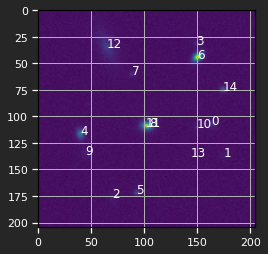

In [5]:
print("input_image")
plt.imshow(blend['blend_images'][0, 2])
for i in range(len(blend['blend_list'][0])):
    plt.text(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], str(i))

input_image


/tmp/ipykernel_1447/2459567947.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  bar = fig.colorbar(im1, ax=ax)


<Figure size 720x720 with 0 Axes>

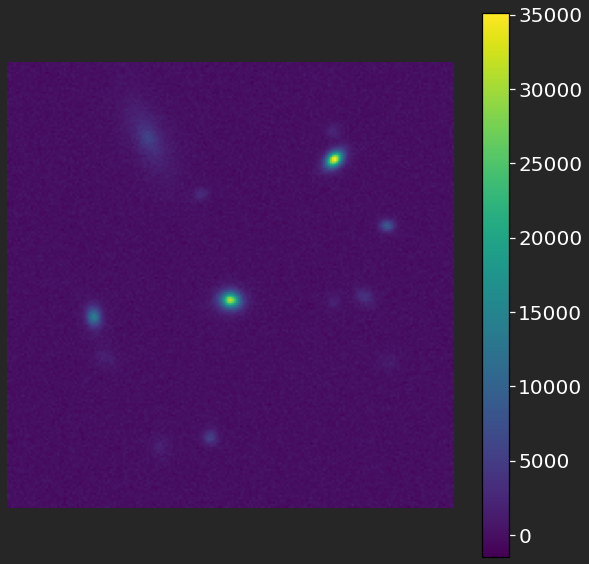

In [6]:
fig = plt.figure(figsize=(10,10))
print("input_image")
fig=plt.figure(figsize=(10,10))
ax=fig.gca()
im1 = ax.imshow(blend['blend_images'][0, 2])
#for i in range(len(blend['blend_list'][0])):
#    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
#                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")
    #plt.text(blend['blend_list'][0]['x_peak'][i]-1, blend['blend_list'][0]['y_peak'][i]-1, str(i), c='black', fontsize=15)
bar = fig.colorbar(im1, ax=ax)
bar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("input field")


# Initialize the Deblender

In [7]:
tf.get_logger().setLevel('ERROR')

detected_positions = []
for i in range(len(blend['blend_list'][0])):
    detected_positions.append([blend['blend_list'][0]['y_peak'][i], blend['blend_list'][0]['x_peak'][i]])

deb = Deblend(blend['blend_images'][0], 
              detected_positions,
              latent_dim=16, 
              num_components=len(blend['blend_list'][0]), 
              use_likelihood=True, 
              linear_norm_coeff=linear_norm_coeff,
              max_iter=500)

2023-02-11 23:32:13.641149: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2023-02-11 23:32:13.641258: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-11 23:32:13.641327: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2023-02-11 23:32:13.641522: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 23

0.001


2023-02-11 23:32:17.118551: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Test run Debvader

In [8]:
deb.run_debvader()

In [9]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 3, figsize=(5*3,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     image_index = i
#     im1 = ax[i, 0].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9))
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 0].set_title("ground truth")
#     ax[i, 0].scatter(22, 22, c="r", marker="x")

#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 1].set_title("predicted")
    
#     im3 = ax[i, 2].imshow(crop_image(blend['isolated_images'][0][i], detected_positions[i], 9) - deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im3, ax=ax[i, 2])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i, 2].set_title("actual - predicted")
    
# plt.show()

/tmp/ipykernel_1447/4083717891.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar =fig.colorbar(im1, ax=ax)


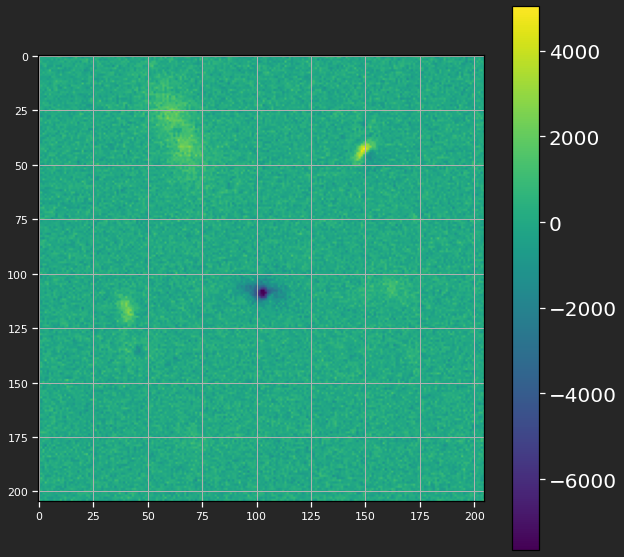

In [10]:
# Residual after debvader run

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 3])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.savefig("residual")

In [11]:
# fig, ax = plt.subplots(len(blend['blend_list'][0]), 2, figsize=(5*2,5*len(blend['blend_list'][0])))

# for i in range(len(blend['blend_list'][0])):

#     im1 = ax[i, 0].imshow(extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2])
#     cbar = fig.colorbar(im1, ax=ax[i, 0])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 0].set_title("ground truth", fontsize=20)
#     ax[i, 0].scatter(22, 22, c="r", marker="x")
#     ax[i, 0].axis('off')


#     im2 = ax[i, 1].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i, 1])
#     cbar.ax.tick_params(labelsize=20)
#     ax[i, 1].set_title("predicted", fontsize=20)
#     ax[i, 1].axis('off')

# plt.show()

# Run MADNESS

In [12]:
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(False)
tf.config.run_functions_eagerly(False)
convergence_criterion = tfp.optimizer.convergence_criteria.LossNotDecreasing(
    atol=0.000001 * 45 * 45 * len(blend) * 3, min_num_steps=80, window_size=20
)
convergence_criterion = tfp.optimizer.convergence_criteria.SuccessiveGradientsAreUncorrelated(min_num_steps=120, window_size=25)
# convergence_criterion = None
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1., decay_steps=25, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)
#optimizer=tfa.optimizers.AdaBelief(learning_rate=lr_scheduler)

deb(convergence_criterion, optimizer=optimizer, use_debvader=True, compute_sig_dynamically=False)

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Using encoder for initial point

--- Starting gradient descent in the latent space ---
Maximum number of iterations: 500
Number of Galaxies: 15
Dimensions of latent space: 16
--- Gradient descent complete ---

Time taken for gradient d

tf.Tensor(
[150048.03  153709.88  139117.06  136809.3   136634.6   134028.89
 132562.73  132838.2   133296.47  132906.44  131798.48  130575.71
 129903.66  129847.01  129969.04  129966.36  129611.88  129173.18
 128927.73  128859.31  128755.18  128551.56  128336.38  128171.21
 128043.92  127937.74  127866.25  127811.86  127748.016 127676.695
 127628.58  127593.516 127535.72  127444.66  127344.336 127281.48
 127257.34  127230.99  127177.63  127114.35  127068.95  127042.164
 127017.3   126978.875 126933.2   126896.05  126871.34  126852.36
 126827.664 126798.04  126774.64  126761.836 126748.984 126731.07
 126710.375 126692.47  126678.83  126663.984 126647.15  126629.56
 126612.28  126594.58  126579.4   126568.555 126557.695 126543.625
 126528.51  126515.33  126502.42  126487.125 126470.54  126455.375
 126441.445 126428.    126417.34  126414.766 126423.92  126440.805
 126423.2   126391.5   126404.53  126370.54  126380.4   126365.28
 126365.19  126359.29  126352.65  126363.414 126348.266 1263

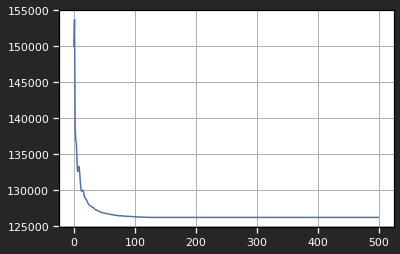

In [13]:
print(deb.results)
plt.plot(deb.results);

/tmp/ipykernel_1447/651321632.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 0])
/tmp/ipykernel_1447/651321632.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im1, ax=ax[i, 1])
/tmp/ipykernel_1447/651321632.py:26: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im2, ax=ax[i, 2])
/tmp/ipykernel_1447/651321632.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb

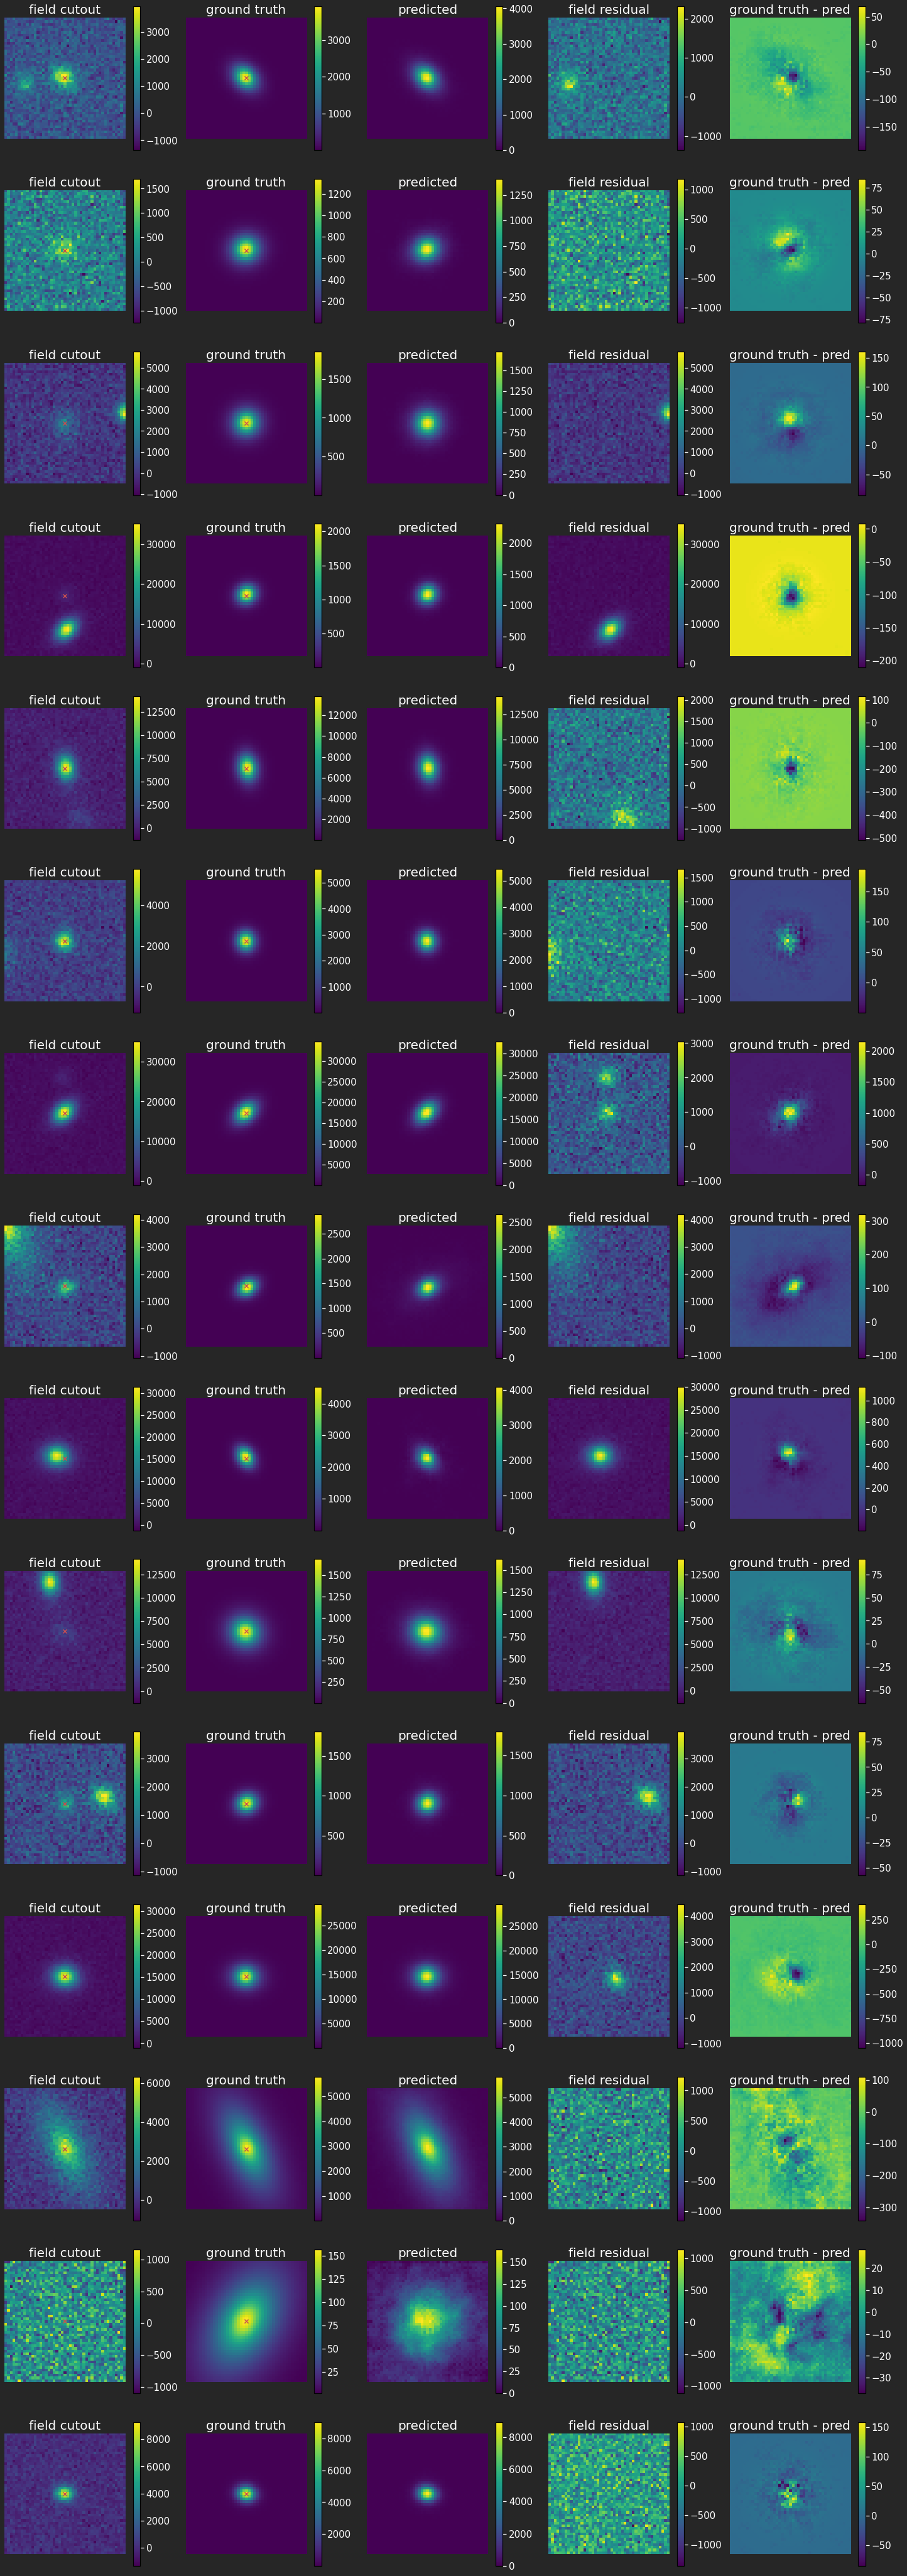

In [14]:
fig, ax = plt.subplots(len(blend['blend_list'][0]), 5, figsize=(5*5,5*len(blend['blend_list'][0])))

for i in range(len(blend['blend_list'][0])):

    #print("image number: " + str(i))
    #image_index = shuffled_indices[i]
    field_cutout_r_band = extract_cutouts(blend['blend_images'][0], [detected_positions[i]], distances_to_center=False, channel_last=False, cutout_size=45)[0][0,:, :, 2]
    galaxy_cutout_r_band = extract_cutouts(blend['isolated_images'][0][i], [detected_positions[i]], distances_to_center=False, cutout_size=45)[0][0, :, :, 2]
    
    im1 = ax[i, 0].imshow(field_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 0])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 0].set_title("field cutout", fontsize=20)
    ax[i, 0].scatter(22, 22, c="r", marker="x")
    ax[i, 0].axis('off')

    im1 = ax[i, 1].imshow(galaxy_cutout_r_band)
    cbar = fig.colorbar(im1, ax=ax[i, 1])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 1].set_title("ground truth", fontsize=20)
    ax[i, 1].scatter(22, 22, c="r", marker="x")
    ax[i, 1].axis('off')


    im2 = ax[i, 2].imshow(deb.components[i][:, :, 2])
    cbar = fig.colorbar(im2, ax=ax[i, 2])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 2].set_title("predicted", fontsize=20)
    ax[i, 2].axis('off')
    
    im3 = ax[i, 3].imshow(field_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 3])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 3].set_title("field residual", fontsize=20)
    ax[i, 3].axis('off')

    
    im3 = ax[i, 4].imshow(galaxy_cutout_r_band - deb.components[i][:, :, 2])
    cbar = fig.colorbar(im3, ax=ax[i, 4])
    cbar.ax.tick_params(labelsize=15)
    ax[i, 4].set_title("ground truth - pred", fontsize=20)
    ax[i, 4].axis('off')

plt.savefig("MAP_predictions")
plt.show()

In [15]:
# fig, ax = plt.subplots(1, len(blend['blend_list'][0]), figsize=(5*len(blend['blend_list'][0]), 5*1))
# for i in range(len(blend['blend_list'][0])):

#     #print("image number: " + str(i))
#     #image_index = shuffled_indices[i]

#     im2 = ax[i].imshow(deb.components[i][:, :, 2])
#     cbar = fig.colorbar(im2, ax=ax[i])
#     cbar.ax.tick_params(labelsize=15)
#     ax[i].axis("off")
#     #ax[i].set_title("predicted")
# plt.savefig("predictions")

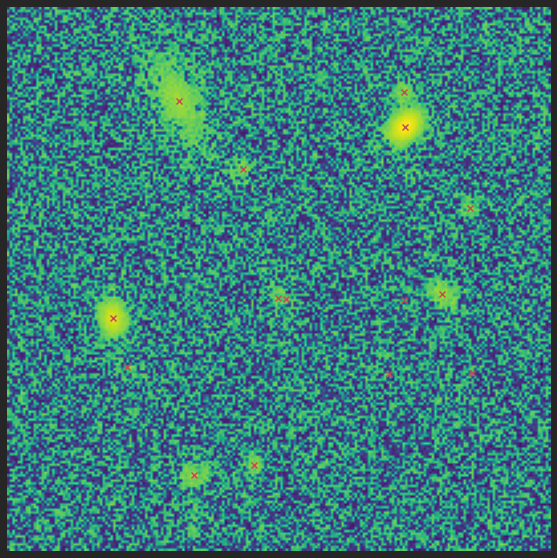

In [16]:
# This is just to make the blends more visible

sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

fig = plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.arcsinh(blend['blend_images'][0][0]))
for i in range(len(blend['blend_list'][0])):
    plt.scatter(blend['blend_list'][0]['x_peak'][i], 
                blend['blend_list'][0]['y_peak'][i], marker="x", c="r")

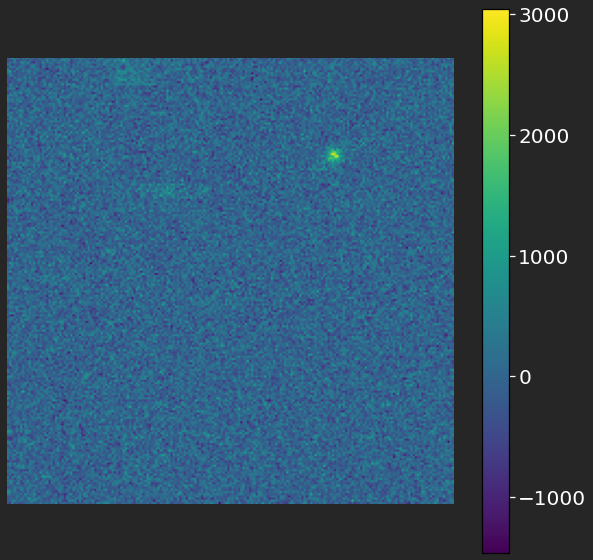

In [17]:
# Residual after MADNESS run
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
tf.config.run_functions_eagerly(True)

padding_infos = deb.get_padding_infos()
residual = deb.compute_residual(np.transpose(blend['blend_images'][0], axes=[1, 2, 0]), use_scatter_and_sub=True).numpy()
#residual = np.transpose(deb.postage_stamp, 
im1 = ax.imshow(residual[:, :, 2])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.savefig("residual")

#for i in range(len(blend['blend_list'][0])):
    #plt.scatter(blend['blend_list'][0]['x_peak'][i], blend['blend_list'][0]['y_peak'][i], marker="x", linewidths=.5, s=120, c="r")

##### sns.set_theme(style={"axes.grid": True,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})

plt.figure(figsize=(8,3))
residual_flattened = residual[:, :, 0].flatten()
print(np.shape(residual_flattened))
plt.hist(residual_flattened, bins=50)
plt.xticks(fontsize=15)
plt.yticks([])

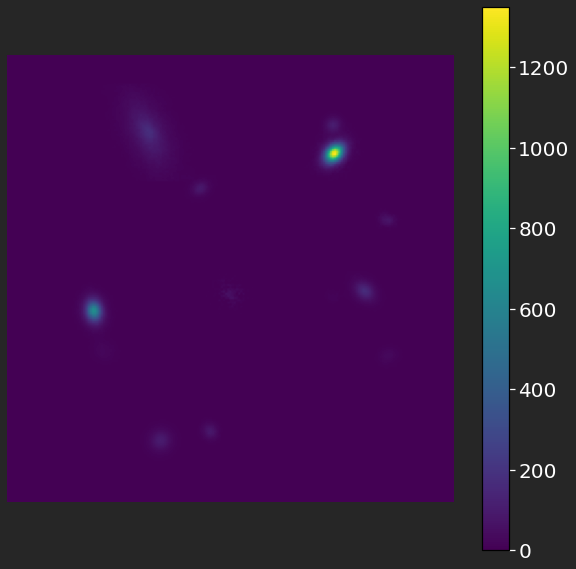

In [18]:
sns.set_theme(style={"axes.grid": False,
                     'axes.labelcolor': 'white',
                     'figure.facecolor': '.15',
                     'xtick.color': 'white',
                     'ytick.color': 'white',
                     'text.color': 'white',
                     'image.cmap': 'viridis',})
predicted_field = blend['blend_images'][0] - np.transpose(residual, axes=[2, 0, 1])
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
im1 = ax.imshow(predicted_field[0, :, :])
cbar =fig.colorbar(im1, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.axis("off")
plt.show();

In [19]:
from maddeb.metrics import compute_reconstruction_metrics
from maddeb.extraction import extract_cutouts

In [20]:
field_size = np.shape(blend['isolated_images'][0][i])[1]

In [21]:
field_image=blend['blend_images'][0]

In [22]:
cutouts, list_idx = extract_cutouts(field_image=blend['blend_images'][0], pos=np.array(detected_positions), cutout_size=45, channel_last=False)

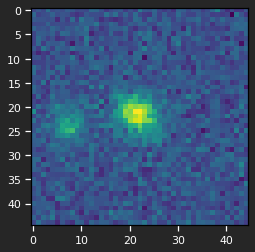

In [23]:
plt.imshow(cutouts[0][:, :, 2])

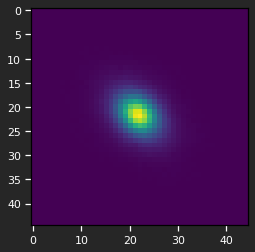

In [24]:
plt.imshow(deb.components[0][:, :, 2])

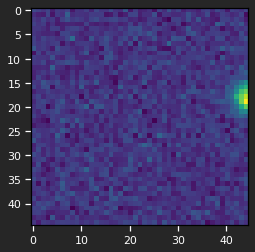

In [25]:
plt.imshow(cutouts[2][:, :, 2]-deb.components[2][:, :, 2])

In [26]:
results=compute_reconstruction_metrics(deb.components, cutouts)

TypeError: Cannot interpret 'tf.float32' as a data type

In [ ]:
plt.hist(results["mse"]);

In [ ]:
plt.hist(results["psnr"]);

In [ ]:
plt.hist(results["ssim"]);